# Binary Image Classification Deep Learning Model for Casting Quality Inspection Using TensorFlow Take 3
### David Lowe
### December 21, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The Casting Quality Inspection dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: This dataset is about the casting process during the manufacturing of a product. A casting defect is an undesired irregularity in a metal casting process, and the significant problem is that most organizations carry out the inspection process manually. It is a very time-consuming process and prone to human errors. These photos are a top view of the submersible pump impeller, and the dataset contains 7348 image files. All images are the size of 300x300 pixels grey-scaled images with image augmentation.

From iteration Take1, we trained a few three-layer CNN models and evaluated them using 715 300x300 pixels test images.

From iteration Take2, we trained a few three-layer CNN models and evaluated them using 1300 512x512 pixels test images.

In this Take3 iteration, we will train a VGG-16 CNN model and evaluate it using the 1300 512x512 pixels test images.

ANALYSIS: From iteration Take1, the baseline model's performance achieved an accuracy score of 99.72% after 15 epochs using the training dataset. After tuning the hyperparameters, the best model processed the validation/test dataset with an accuracy score of 99.86%.

From iteration Take2, the baseline model's performance achieved an accuracy score of 72.62% after 15 epochs using the training dataset. After tuning the hyperparameters, the best model processed the validation/test dataset with an accuracy score of 72.62%.

In this Take3 iteration, the VGG16 model's performance achieved an accuracy score of 100% after 20 epochs using the training dataset. The same model processed the validation/test dataset with an accuracy score of 73.92%.

CONCLUSION: In this iteration, the VGG16 CNN model appeared to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.

Dataset Used: Casting Quality Inspection Dataset

Dataset ML Model: Binary image classification with numerical attributes

Dataset Reference: https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product

One potential source of performance benchmarks: https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product/notebooks

A deep-learning image classification project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Images
3. Define and Train Models
4. Evaluate and Optimize Models
5. Finalize Model and Make Predictions

# Task 1 - Prepare Environment

In [1]:
# Install the packages to support accessing environment variable and SQL databases
!pip install python-dotenv PyMySQL

     |████████████████████████████████| 51kB 4.7MB/s 


In [2]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Thu Dec 10 16:35:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


## 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
seedNum = 888

In [6]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
# import boto3
import zipfile
from datetime import datetime
from dotenv import load_dotenv
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

## 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
TEST_SET_SIZE = 0.2
VAL_SET_SIZE = 0.2

# Set various default modeling parameters
DEFAULT_LOSS = 'binary_crossentropy'
DEFAULT_METRICS = ['accuracy']
# DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
DEFAULT_OPTIMIZER = tf.keras.optimizers.SGD(learning_rate=0.01)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomUniform(seed=seedNum)
EPOCH_NUMBER = 20
BATCH_SIZE = 16
IMAGE_SIZE = (300, 300)
IMAGE_SHAPE = (300, 300, 3)

# Define the labels to use for graphing the data
train_metric = 'accuracy'
validation_metric = 'val_accuracy'
train_loss = 'loss'
validation_loss = 'val_loss'

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.3.0


In [8]:
# Set up the parent directory location for loading the dotenv files
# useColab = True
# if useColab:
#     # Mount Google Drive locally for storing files
#     from google.colab import drive
#     drive.mount('/content/gdrive')
#     gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
#     env_path = '/content/gdrive/My Drive/Colab Notebooks/'
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
# useLocalPC = True
# if useLocalPC:
#     env_path = "/Users/david/PycharmProjects/"
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

In [9]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [10]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [11]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [12]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [13]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [14]:
# Clean up the old files and download directories before receiving new ones
!rm -rf staging/
!rm archive_casting.zip

rm: cannot remove 'archive_casting.zip': No such file or directory


In [15]:
!wget https://dainesanalytics.com/datasets/kaggle-casting-quality-inspection/archive_casting.zip

--2020-12-10 16:35:05--  https://dainesanalytics.com/datasets/kaggle-casting-quality-inspection/archive_casting.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.227.209.36, 13.227.209.71, 13.227.209.61, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.227.209.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104965698 (100M) [application/zip]
Saving to: ‘archive_casting.zip’

archive_casting.zip 100%[===================>] 100.10M  17.9MB/s    in 6.5s    

2020-12-10 16:35:12 (15.4 MB/s) - ‘archive_casting.zip’ saved [104965698/104965698]



In [16]:
staging_dir = 'staging/'
!mkdir staging/

In [17]:
local_zip = 'archive_casting.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(staging_dir)
zip_ref.close()

In [18]:
training_dir = 'staging/casting_data/casting_data/train/'
validation_dir = 'staging/casting_512x512/casting_512x512/'
classA_name = 'def_front'
classB_name = 'ok_front'

In [19]:
# Brief listing of training image files for class A
training_classA_dir = os.path.join(training_dir, classA_name)
training_classA_files = os.listdir(training_classA_dir)
print('Number of training images for', classA_name, ':', len(os.listdir(training_classA_dir)))
print('Training samples for', classA_name, ':', training_classA_files[:10])

# Brief listing of training image files for class B
training_classB_dir = os.path.join(training_dir, classB_name)
training_classB_files = os.listdir(training_classB_dir)
print('Number of training images for', classB_name, ':', len(os.listdir(training_classB_dir)))
print('Training samples for', classB_name, ':', training_classB_files[:10])

Number of training images for def_front : 3758
Training samples for def_front : ['cast_def_0_3474.jpeg', 'cast_def_0_8759.jpeg', 'cast_def_0_2805.jpeg', 'cast_def_0_7845.jpeg', 'cast_def_0_3590.jpeg', 'cast_def_0_5881.jpeg', 'cast_def_0_8659.jpeg', 'cast_def_0_2779.jpeg', 'cast_def_0_2024.jpeg', 'cast_def_0_320.jpeg']
Number of training images for ok_front : 2875
Training samples for ok_front : ['cast_ok_0_8276.jpeg', 'cast_ok_0_1040.jpeg', 'cast_ok_0_3441.jpeg', 'cast_ok_0_2589.jpeg', 'cast_ok_0_7013.jpeg', 'cast_ok_0_8015.jpeg', 'cast_ok_0_4238.jpeg', 'cast_ok_0_3470.jpeg', 'cast_ok_0_3453.jpeg', 'cast_ok_0_1819.jpeg']


In [20]:
# Brief listing of validation image files for class A
validation_classA_dir = os.path.join(validation_dir, classA_name)
validation_classA_files = os.listdir(validation_classA_dir)
print('Number of validation images for', classA_name, ':', len(os.listdir(validation_classA_dir)))
print('Validation samples for', classA_name, ':', validation_classA_files[:10])

# Brief listing of validation image files for class B
validation_classB_dir = os.path.join(validation_dir, classB_name)
validation_classB_files = os.listdir(validation_classB_dir)
print('Number of validation images for', classB_name, ':', len(os.listdir(validation_classB_dir)))
print('Validation samples for', classB_name, ':', validation_classB_files[:10])

Number of validation images for def_front : 781
Validation samples for def_front : ['cast_def_0_9051.jpeg', 'cast_def_0_102.jpeg', 'cast_def_0_5805.jpeg', 'cast_def_0_9640.jpeg', 'cast_def_0_9619.jpeg', 'cast_def_0_7384.jpeg', 'cast_def_0_8510.jpeg', 'cast_def_0_3098.jpeg', 'cast_def_0_8813.jpeg', 'cast_def_0_2649.jpeg']
Number of validation images for ok_front : 519
Validation samples for ok_front : ['cast_ok_0_5370.jpeg', 'cast_ok_0_7690.jpeg', 'cast_ok_0_1959.jpeg', 'cast_ok_0_2695.jpeg', 'cast_ok_0_2315.jpeg', 'cast_ok_0_277.jpeg', 'cast_ok_0_6189.jpeg', 'cast_ok_0_5009.jpeg', 'cast_ok_0_872.jpeg', 'cast_ok_0_5181.jpeg']


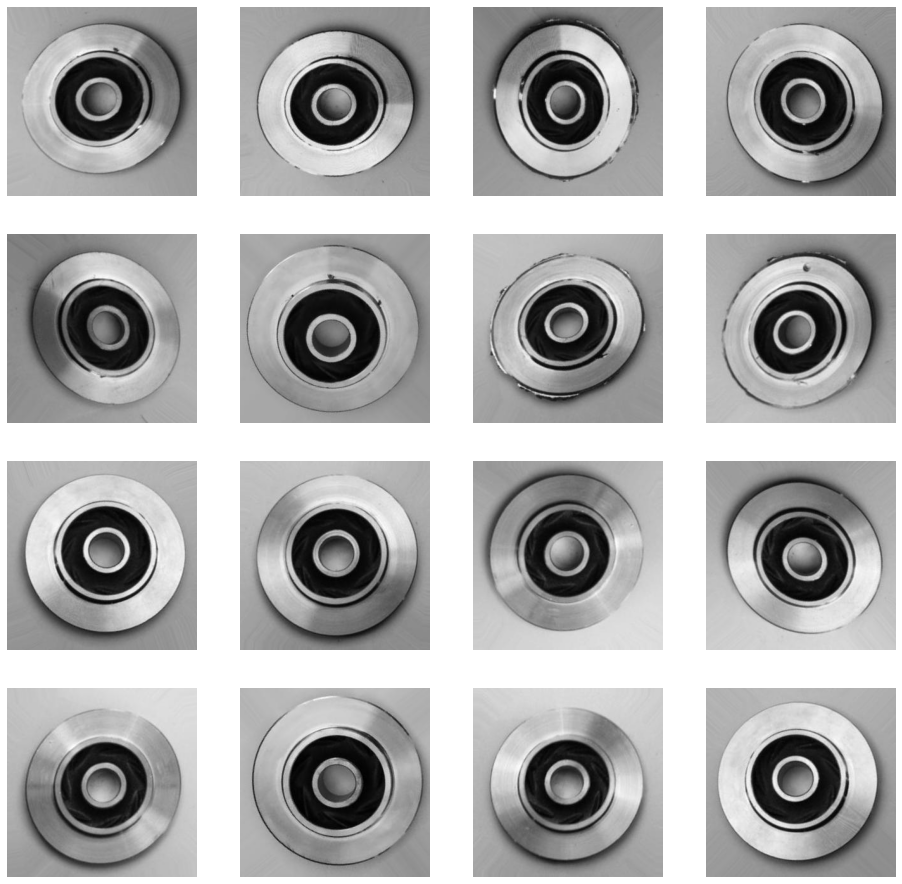

In [21]:
# Plot some training images from the dataset
nrows = 4
ncols = 4

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

reset_random(seedNum)
number_elements = ncols * 2
random_training_classA = random.sample(training_classA_files, number_elements)
random_training_classB = random.sample(training_classB_files, number_elements)
next_classA = [os.path.join(training_classA_dir, fname) for fname in random_training_classA]
next_classB = [os.path.join(training_classB_dir, fname) for fname in random_training_classB]

for i, img_path in enumerate(next_classA + next_classB):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()

In [22]:
# Set up the generators for the training and validation datasets
datagen_kwargs = dict(rescale=1./255)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='binary')

print('Loading and pre-processing the validation images...')
validation_datagen = ImageDataGenerator(**datagen_kwargs)
validation_generator = validation_datagen.flow_from_directory(validation_dir, shuffle=False, **dataflow_kwargs)
print('Number of image batches per epoch of modeling:', len(validation_generator))

do_data_augmentation = False 
if do_data_augmentation:
    training_datagen = ImageDataGenerator(
        rotation_range=45,
        horizontal_flip=True,
        vertical_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        **datagen_kwargs)
else:
    training_datagen = validation_datagen

print('\nLoading and pre-processing the training images...')
training_generator = training_datagen.flow_from_directory(training_dir, shuffle=True, **dataflow_kwargs)
print('Number of image batches per epoch of modeling:', len(training_generator))

Loading and pre-processing the validation images...
Found 1300 images belonging to 2 classes.
Number of image batches per epoch of modeling: 82

Loading and pre-processing the training images...
Found 6633 images belonging to 2 classes.
Number of image batches per epoch of modeling: 415


In [23]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [24]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [25]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [train_loss, train_metric]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
#         if metric == train_loss:
#             plt.ylim([0, plt.ylim()[1]])
#         else:
#             plt.ylim([0.5, 1.1])
        plt.legend()

In [26]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=IMAGE_SHAPE, output_param=1, opt_param=DEFAULT_OPTIMIZER, init_param=DEFAULT_INITIALIZER, loss_param=DEFAULT_LOSS, metrics_paranm=DEFAULT_METRICS):
    nn_model = keras.applications.VGG16(include_top=True, weights=None, input_shape=input_param, classes=output_param, classifier_activation='sigmoid')
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_paranm)
    return nn_model

In [27]:
# Initialize the neural network model and get the training results for plotting graph
startTimeModule = datetime.now()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.5, min_lr=0.00001)
reset_random(seedNum)
nn_model_0 = create_nn_model()
nn_model_history = nn_model_0.fit(
    training_generator,
    steps_per_epoch=len(training_generator),
	validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=EPOCH_NUMBER,
    callbacks=[learning_rate_reduction],
    verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/20
415/415 [==============================] - 61s 148ms/step - loss: 0.6853 - accuracy: 0.5667 - val_loss: 0.6747 - val_accuracy: 0.6008
Epoch 2/20
415/415 [==============================] - 60s 145ms/step - loss: 0.6814 - accuracy: 0.5666 - val_loss: 0.6640 - val_accuracy: 0.6008
Epoch 3/20
415/415 [==============================] - 60s 145ms/step - loss: 0.6173 - accuracy: 0.6391 - val_loss: 0.5935 - val_accuracy: 0.7208
Epoch 4/20
415/415 [==============================] - 60s 145ms/step - loss: 0.4141 - accuracy: 0.7996 - val_loss: 1.1219 - val_accuracy: 0.6669
Epoch 5/20
415/415 [==============================] - 60s 145ms/step - loss: 0.2786 - accuracy: 0.8735 - val_loss: 0.5637 - val_accuracy: 0.7738
Epoch 6/20
415/415 [==============================] - 60s 145ms/step - loss: 0.1910 - accuracy: 0.9255 - val_loss: 0.6870 - val_accuracy: 0.7354
Epoch 7/20
415/415 [==============================] - ETA: 0s - loss: 0.1205 - accuracy: 0.9570
Epoch 00007: ReduceLROnPlateau red

In [28]:
nn_model_0.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

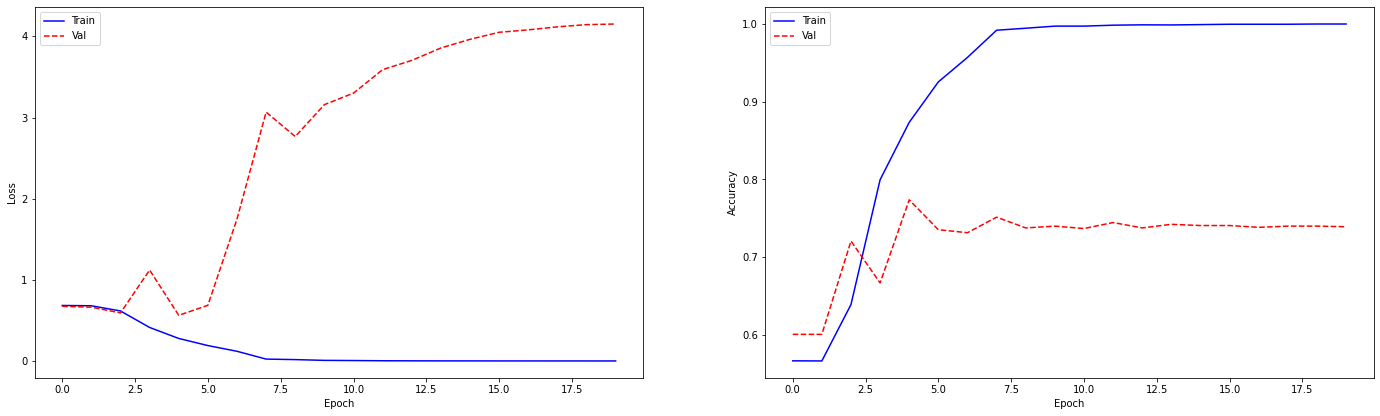

In [29]:
plot_metrics(nn_model_history)

In [30]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Evaluate and Optimize Models

In [31]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 4 - Evaluate and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [32]:
# Not applicable for this iteration of modeling

In [33]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 4 - Evaluate and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [34]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [35]:
# Initialize the neural network model and train the final model
final_model = nn_model_0

# Display a summary of the final model
final_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [36]:
# Print the labels used for the modeling
print(validation_generator.class_indices)

{'def_front': 0, 'ok_front': 1}


In [37]:
final_model.evaluate(validation_generator, verbose=1)

82/82 [==============================] - 8s 95ms/step - loss: 4.1534 - accuracy: 0.7392


[4.153445720672607, 0.739230751991272]

In [38]:
test_pred = final_model.predict(validation_generator)
test_predictions = (test_pred > 0.5).astype('int').ravel()
test_original = validation_generator.labels
print('Accuracy Score:', accuracy_score(test_original, test_predictions))
print(confusion_matrix(test_original, test_predictions))
print(classification_report(test_original, test_predictions))

Accuracy Score: 0.7392307692307692
[[712  69]
 [270 249]]
              precision    recall  f1-score   support

           0       0.73      0.91      0.81       781
           1       0.78      0.48      0.59       519

    accuracy                           0.74      1300
   macro avg       0.75      0.70      0.70      1300
weighted avg       0.75      0.74      0.72      1300



In [39]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [40]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:20:47.404547
